In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import *
from keras.utils import np_utils
from nltk.tokenize import RegexpTokenizer
from keras.models import Model,load_model
from keras.callbacks import ModelCheckpoint
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
from sklearn.feature_extraction import text as sktext
from sklearn import preprocessing as skp
from keras import callbacks as kc
from keras import optimizers as ko
from keras import initializers, regularizers, constraints
from keras.engine import Layer
import keras.backend as K
from sklearn.metrics import f1_score
from keras.utils.vis_utils import model_to_dot
from keras import models
from keras import layers
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, Flatten, GlobalAveragePooling1D, Reshape
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import Constant


Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
df = pd.read_csv('final_HEOT_data.csv')

In [4]:
df.head()

,Unnamed: 0,Unnamed: 0.1,label,tweet,tokens,stem,lemmas,text
0,0,0,0.0,@saud5683 @Mutayyab420 @shivang598 @Ranask35 @...,"['user', 'user', 'user', 'user', 'user', 'user...",us us us us us us us us haa jais tum bhi abh p...,user user user user user user user user haa ja...,User user user user user user user user yes li...
1,1,2,2.0,"Banti hai empowered woman, feminism pe gyan pe...","['banti', 'hai', 'empowered', 'woman', 'femini...",bant hai empow wom femin pe gyan pelt hai aur ...,banti hai empower woman feminism pe gyan pelti...,Becomes Empowered Woman Feminism thrives and w...
2,2,4,2.0,RT @kim_jong_korea: @updatingwait @Acutereply ...,"['rt', 'user', 'user', 'user', 'ab', 'usko', '...",rt us us us ab usko chhod mjse bat kr ter baap...,rt user user user ab usko chhod mjse bat kr te...,"Rat user, user, user, leave him now, which thi..."
3,3,6,2.0,@InviSibleSold @mabkhan86 @dridadahn Punjab in...,"['user', 'user', 'user', 'punjab', 'in', 'mada...",us us us punjab in madarchodon ko khil rah hai...,user user user punjab in madarchodon ko khila ...,USER USER USER PUNJAB FEATURING MADARCHODO IS ...
4,4,8,2.0,RT @MrMonsterSaid: Agar koi bole ki ja ke chil...,"['rt', 'user', 'agar', 'koi', 'bole', 'ki', 'j...",rt us ag koi bol ki ja ke chil maar to madarch...,rt user agar koi bole ki ja ke chill maar to m...,"Rat user if someone says to kill, then to kill..."


In [5]:
df['label'] = df['label'].astype(int)

In [6]:
df = df.drop(['Unnamed: 0'], axis=1)

In [7]:
train_df = pd.DataFrame()
train_df['content'] = df['lemmas']
train_df['class'] = df['label']


Training data phrase length distribution


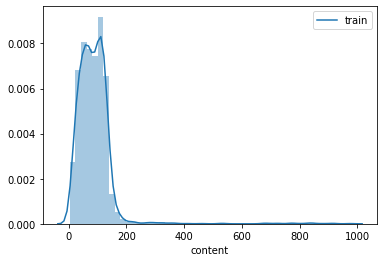

In [8]:
print("Training data phrase length distribution")
sns.distplot(train_df['content'].map(lambda ele: len(ele)), kde_kws={"label": "train"})

In [9]:
print('Most frequent sentence length in training:')
lens = train_df['content'].map(lambda ele: len(ele))
counts = np.bincount(lens)
print(np.argmax(counts))

Most frequent sentence length in training:
55


Testing data phrase length distribution


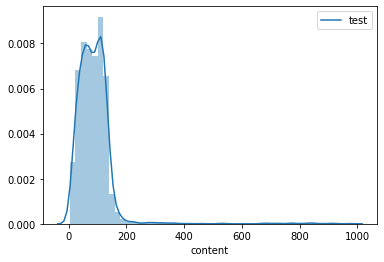

In [10]:
print("Testing data phrase length distribution")
sns.distplot(train_df['content'].map(lambda ele: len(ele)), kde_kws={"label": "test"})

In [11]:
test_df = train_df[2800:]
train_df = train_df[:2800]

In [12]:
test_df.shape

(389, 2)

Testing data phrase length distribution


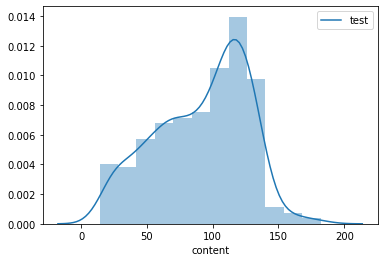

In [13]:
print("Testing data phrase length distribution")
sns.distplot(test_df['content'].map(lambda ele: len(ele)), kde_kws={"label": "test"})

In [14]:
test_df.shape

(389, 2)

In [15]:
print('Most frequent sentence length in testing:')
lens = test_df['content'].map(lambda ele: len(ele))
counts = np.bincount(lens)
print(np.argmax(counts))

Most frequent sentence length in testing:
115


In [16]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [17]:

## A dictionary to map the punctuations present in the text to relevant strings or symbols
punct_mapping = {"‘": "'", 
                 "₹": "e", 
                 "´": "'", 
                 "°": "", 
                 "€": "e", 
                 "™": "tm",
                 "√": " sqrt ",
                 "×": "x",
                 "²": "2",
                 "—": "-",
                 "–": "-",
                 "’": "'",
                 "_": "-",
                 "`": "'",
                 '“': '"',
                 '”': '"',
                 '“': '"',
                 "£": "e",
                 '∞': 'infinity',
                 'θ': 'theta',
                 '÷': '/',
                 'α': 'alpha',
                 '•': '.',
                 'à': 'a',
                 '−': '-',
                 'β': 'beta',
                 '∅': '',
                 '³': '3',
                 'π': 'pi',
                 ',':'',
                 '.':'',
                 ':':'',
                 '(':'',
                 ')':'',
                 '*':'',
                '"':'',
                '<':'',
                '>':''}

In [18]:
def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

## Function to remove special characters from the sentences (if any present)
def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

In [19]:
train_df.loc[:, 'content'] = train_df['content'].map(lambda text: clean_special_chars(text, punct, punct_mapping))
test_df.loc[:, 'content'] = test_df['content'].map(lambda text: clean_special_chars(text, punct, punct_mapping))

In [20]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [21]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [22]:
train_df.loc[:, 'content'] = train_df['content'].map(lambda text: clean_contractions(text, contraction_mapping))
test_df.loc[:, 'content'] = test_df['content'].map(lambda text: clean_contractions(text, contraction_mapping))

In [23]:
train_df.loc[:, 'content'] = train_df['content'].map(lambda text: text.lower())
test_df.loc[:, 'content'] = test_df['content'].map(lambda text: text.lower())

In [24]:
data = train_df.values
data_test = test_df.values

In [25]:
X_train = data[:,0]
Y_train = data[:,1]

X_test = data_test[:,0]
Y_test = data_test[:,1]

print (X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
print ("-------------------------")
print (X_test[0], Y_test[0])
print (X_train[0], Y_train[0])

(2800,) (2800,) (389,) (389,)
-------------------------
itna maar khayega man why do not you understand 0
user user user user user user user user haa jaise tum bhi abhi pxe2x80xa6 url 0


In [26]:
tokenizer = RegexpTokenizer("[a-zA-Z]+")
lemmatizer = WordNetLemmatizer()

In [27]:
import nltk
nltk.download('wordnet')

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [28]:
for ix in range(X_train.shape[0]):
    X_train[ix] = tokenizer.tokenize(X_train[ix])
    X_train[ix] = [lemmatizer.lemmatize(i) for i in X_train[ix]]
    
for ix in range(X_test.shape[0]):
    X_test[ix] = tokenizer.tokenize(X_test[ix])
    X_test[ix] = [lemmatizer.lemmatize(i) for i in X_test[ix]]

In [29]:
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
#     print(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
## Length of the list of unique_words gives the no of unique words
print("Vocabulary Size:")
print(len(list(unique_words)))
print("Maximum length of sentence:")
print(len_max)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [00:00<00:00, 389766.39it/s]


Vocabulary Size:
7656
Maximum length of sentence:
295


In [30]:
tokenizer_keras = Tokenizer(num_words=len(list(unique_words)))
tokenizer_keras.fit_on_texts(list(X_train))
X_train = tokenizer_keras.texts_to_sequences(X_train)
X_test = tokenizer_keras.texts_to_sequences(X_test)

## Padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
## Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.
X_train = sequence.pad_sequences(X_train, maxlen=len_max, padding='post')
X_test = sequence.pad_sequences(X_test, maxlen=len_max, padding='post')
print(X_train.shape,X_test.shape)

(2800, 295) (389, 295)


In [31]:
sequence.pad_sequences?

In [32]:
embeddings_index = dict()

In [33]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts

In [34]:
model = gensim.models.Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

NameError: name 'gensim' is not defined

In [ ]:
word_vectors = model.wv

In [35]:
embeddings_index = dict()

In [ ]:
for sent in data[:,0]:
    for token in sent:
        word = token
        word = lemmatizer.lemmatize(word)
        try:
            coefs = np.asarray(word_vectors[word], dtype='float32')
#             print(coefs)
#             print(coefs.shape)
            embeddings_index[word] = coefs
        except:
#             print(word)
            coefs = np.zeros((200,))
            embeddings_index[word] = coefs

In [36]:
vocab_size=len(list(unique_words))
embedding_matrix = np.zeros((vocab_size+1, 200))
for word, i in tokenizer_keras.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [37]:
embed_size = 200
max_features = vocab_size + 1 

In [39]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [40]:
text_input_layer = Input(shape=(len_max,), dtype='int32')
doc_embedding   = Embedding(len(list(unique_words))+1,
                            200,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=len_max)(text_input_layer)

convs = []
filter_sizes = [4, 5]
# filter_sizes = [5]

l_conv = Conv1D(filters=128, kernel_size=[3], padding='valid', activation='relu')(doc_embedding)

for filter_size in filter_sizes:
    l_conv = Conv1D(filters=128, kernel_size=filter_size, padding='valid', activation='relu')(l_conv)
    convs.append(l_conv)
cnn_feature_maps = convs

reg_drop = Dropout(0.3)(l_conv)
# flat = Flatten()(reg_drop)
sentence_encoder1 = Bidirectional(LSTM(128,return_sequences=True))(reg_drop)
sentence_encoder2 = Bidirectional(LSTM(128,return_sequences=True))(sentence_encoder1)
att = Attention(63)(sentence_encoder2)
fc_layer =Dense(128, activation="relu")(att)
output_layer = Dense(2,activation="softmax")(fc_layer)

model_1 = Model(inputs=[text_input_layer], outputs=[output_layer])

TypeError: add_weight() got multiple values for argument 'name'

In [ ]:
checkpoint=ModelCheckpoint('model_self_embedding_final.h5',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

In [ ]:
X_full = np.concatenate((X_train, X_test))
Y_full = np.concatenate((Y_train, Y_test))

In [ ]:
Y_full = np_utils.to_categorical(Y_full)

In [ ]:
from sklearn import model_selection
x_train, x_test, y_train, y_test = model_selection.train_test_split(X_full, Y_full, random_state=3, test_size=0.2)

In [ ]:
model_1.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model_1.summary()

In [ ]:
file_path = "weights_base_[C-LSTM].best.hdf5"
early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=10)
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=2, save_best_only=True, mode='max')

In [ ]:
hist = model_1.fit(x_train,y_train,validation_data=(x_test,y_test),
                epochs = 10, batch_size=16,shuffle=True,callbacks=[checkpoint,early_stopping])

In [ ]:
pred_val = model_1.predict(x_test)

In [ ]:
pred_val = pred_val.argmax(axis=1)

In [ ]:
true = y_test.argmax(axis=1)

In [ ]:
final = pd.DataFrame()
final['true'] = true.astype(int)
final['pred'] = pred_val.astype(int)

In [ ]:
f1_score(final['true'],final['pred'], average=None)

In [ ]:
print(classification_report(final['true'], final['pred']))